# Projekt końcowy z przedmiotu "Analiza danych przestrzennych"
# *Identyfikacja optymalnych lokalizacji stacji ładowania pojazdów elektrycznych z wykorzystaniem metod analizy danych przestrzennych*

Autorzy: Kacper Błaszczyk 251485, Klim Hudzenko 253833 <br>
Rok akademicki: 2025/2026 <br>
Semestr: 5

## 1. Cel
Celem projektu była identyfikacja optymalnych lokalizacji dla nowych stacji ładowania pojazdów elektrycznych na obszarze danego miasta z wykorzystaniem metod analizy danych przestrzennych.

Projekt obejmuje:
- pozyskanie danych przestrzennych
- podział obszaru analizy
- określenie punktów zainteresowania (POI) oraz istniejących stacji ładowania
- wyznaczenie metryki potencjału lokalizacyjnego dla każdej komórki
- wizualizację wyników w postaci mapy

## 2. Wymagania

Wymagane biblioteki:
1. `osmnx`
2. `geopandas`
3. `matplotlib`
4. `srai`
5. `folium`
6. `shapely`

## 3. Analiza

### 3.1. Import bibliotek

In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from srai.regionalizers import H3Regionalizer
import folium
from shapely.geometry import Point

### 3.2. Konfiguracja - wybór obszaru analizy

Określenie miasta na obszarze którego zostanie przeprowadzona analiza.

In [3]:
PLACE_NAME = "Warszawa, Poland"
CRS_PROJ = "EPSG:2180"

### 3.3. Pobranie danych

Dane przestrzenne dla badanego miasta pobrano z OpenStreetMap, obejmują:
1. granice miasta
2. lokalizacje istniejących stacji ładowania
3. lokalizacje punktów użyteczności publicznej

In [4]:
print("--- ROZPOCZYNAM POBIERANIE DANYCH ---")

print(f"1. Pobieram granice dla: {PLACE_NAME}...")
city_boundary = ox.geocode_to_gdf(PLACE_NAME)
city_boundary = city_boundary.to_crs(CRS_PROJ)

print("2. Pobieram istniejące stacje ładowania...")
tags_charging = {'amenity': 'charging_station'}
charging_stations = ox.features_from_place(PLACE_NAME, tags=tags_charging)

charging_stations = charging_stations[charging_stations.geom_type == 'Point']
charging_stations = charging_stations.to_crs(CRS_PROJ)

print("3. Pobieram punkty POI (centra handlowe, biura)...")
tags_poi = {
    'shop': ['mall', 'supermarket', 'department_store'],
    'amenity': ['cinema', 'theatre', 'university', 'restaurant'],
    'building': ['office', 'commercial', 'retail']
}
pois = ox.features_from_place(PLACE_NAME, tags=tags_poi)

pois = pois.to_crs(CRS_PROJ)
pois['geometry'] = pois.geometry.centroid
pois = pois[pois.geom_type == 'Point']

print(f"\n--- SUKCES! POBRANO DANE ---")
print(f"Liczba stacji ładowania: {len(charging_stations)}")
print(f"Liczba punktów POI: {len(pois)}")

--- ROZPOCZYNAM POBIERANIE DANYCH ---
1. Pobieram granice dla: Warszawa, Poland...
2. Pobieram istniejące stacje ładowania...
3. Pobieram punkty POI (centra handlowe, biura)...

--- SUKCES! POBRANO DANE ---
Liczba stacji ładowania: 180
Liczba punktów POI: 12947


### 3.4. Wizualizacja danych wejściowych

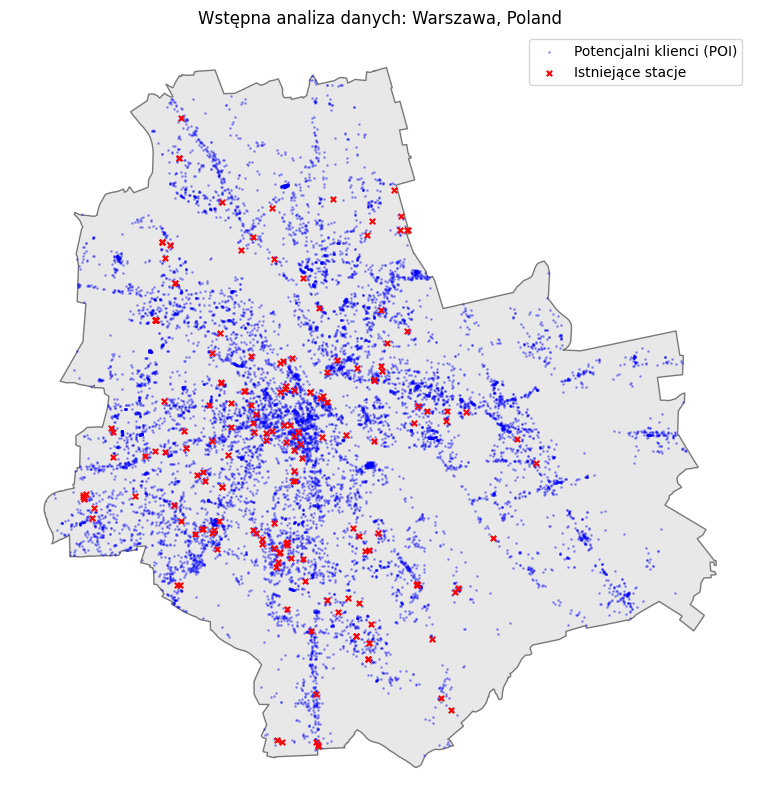

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
city_boundary.plot(ax=ax, color='lightgrey', alpha=0.5, edgecolor='black')
pois.plot(ax=ax, color='blue', markersize=1, alpha=0.3, label='Potencjalni klienci (POI)')
charging_stations.plot(ax=ax, color='red', markersize=15, marker='x', label='Istniejące stacje')
plt.legend()
plt.title(f"Wstępna analiza danych: {PLACE_NAME}")
plt.axis('off')
plt.show()

### 3.5. Podział na heksagonalną siatkę

In [6]:
RESOLUTION = 9

print(f"Generuję siatkę H3 (rozdzielczosc {RESOLUTION})...")

regionalizer = H3Regionalizer(resolution=RESOLUTION)

city_boundary_4326 = city_boundary.to_crs("EPSG:4326")
grid = regionalizer.transform(city_boundary_4326)
grid = grid.reset_index()

if 'region_id' in grid.columns:
    grid = grid.rename(columns={'region_id': 'h3_id'})

Generuję siatkę H3 (rozdzielczosc 9)...


### 3.6. Ocena lokalizacji - metryka potencjału lokalizacyjnego

Dla każdej komórki określonej siatki wyznaczana jest ocena atrakcyjności lokalizacji. Metryka potencjału lokalizacyjnego została określona wzorem:
$$
\text{MPL}_i = N^{\text{POI}}_{i} - \omega \cdot N^{\text{station}}_{i}
$$
gdzie:
- $\text{MPL}_i$ - metryka potencjału lokalizacyjnego $i$-tej komórki
- $N^{\text{POI}}_{i}$ - liczba punktów POI w $i$-tej komórce
- $N^{\text{station}}_{i}$ - liczba istniejących stacji w $i$-tej komórce
- $\omega$ - współczynnik wpływu istniejących stacji (w analizie przyjęto $\omega = 10$)


In [7]:
grid = grid.to_crs(CRS_PROJ)
print(f"SUKCES! Utworzono {len(grid)} heksagonów.")

print("Zliczam punkty...")

pois = pois.to_crs(CRS_PROJ)
charging_stations = charging_stations.to_crs(CRS_PROJ)

join_poi = gpd.sjoin(grid, pois, how='inner', predicate='intersects')
poi_counts = join_poi.groupby('h3_id').size().reset_index(name='poi_count')
grid = grid.merge(poi_counts, on='h3_id', how='left').fillna({'poi_count': 0})

join_stat = gpd.sjoin(grid, charging_stations, how='inner', predicate='intersects')
stat_counts = join_stat.groupby('h3_id').size().reset_index(name='station_count')
grid = grid.merge(stat_counts, on='h3_id', how='left').fillna({'station_count': 0})

grid['score_basic'] = grid['poi_count'] - (grid['station_count'] * 10)

print("\nTOP 5 Lokalizacji:")
print(grid[['h3_id', 'poi_count', 'station_count', 'score_basic']].sort_values('poi_count', ascending=False).head(5))

SUKCES! Utworzono 5575 heksagonów.
Zliczam punkty...

TOP 5 Lokalizacji:
                h3_id  poi_count  station_count  score_basic
5333  891f53c984bffff      105.0            0.0        105.0
4728  891f53ca677ffff       83.0            0.0         83.0
4149  891f53c8277ffff       50.0            0.0         50.0
5538  891f53c852fffff       46.0            0.0         46.0
517   891f52265d3ffff       45.0            0.0         45.0


### 3.7. Wizualizacja oceny - potencjału lokalizacyjnego

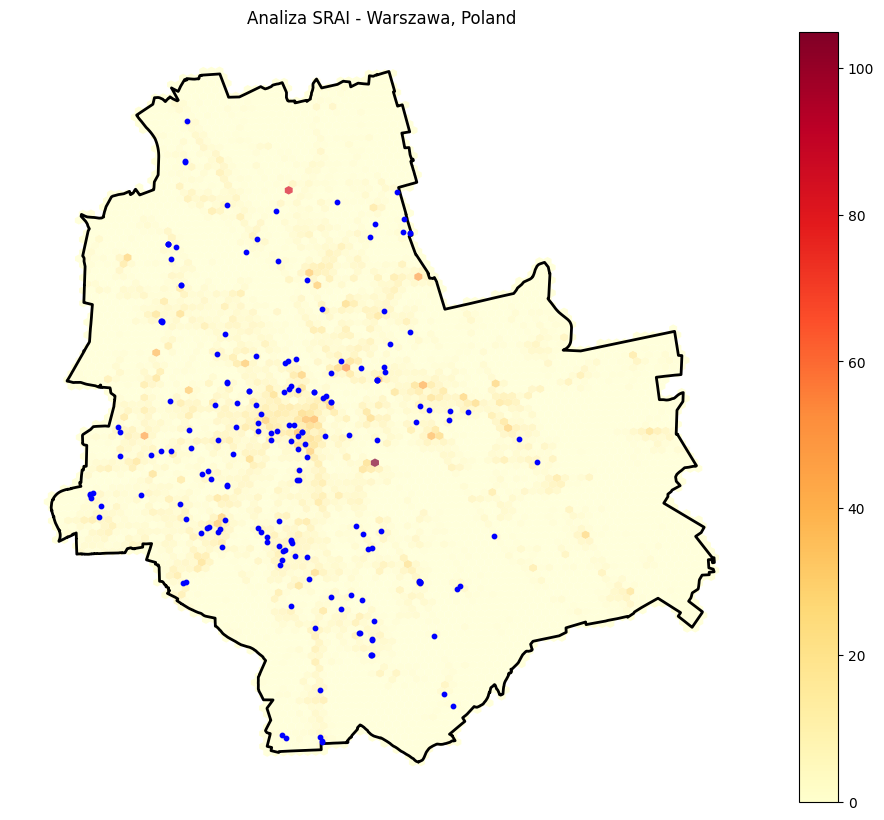

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
grid.plot(ax=ax, column='poi_count', cmap='YlOrRd', alpha=0.7, legend=True)
city_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
charging_stations.plot(ax=ax, color='blue', markersize=10, label='Stacje')
plt.title(f"Analiza SRAI - {PLACE_NAME}")
plt.axis('off')
plt.show()

### 3.8. Selekcja wyników

Ostateczne wyniki są wybierane spośród pięciu najlepszych lokalizacji, z dodatkowym warunkiem minimalnej odległości między wybranymi punktami.

In [9]:
print("--- SELEKCJA I MAPA ---")

candidates = grid.sort_values('score_basic', ascending=False).copy()

final_sites = []
# Minimalna odległość między naszymi nowymi stacjami (w metrach)
MIN_DISTANCE = 1500

print(f"Szukam 5 lokalizacji oddalonych od siebie o min. {MIN_DISTANCE}m...")

for index, row in candidates.iterrows():
    if len(final_sites) >= 5:
        break

    current_point = row.geometry.centroid

    is_far_enough = True
    for site in final_sites:
        existing_point = site.geometry.centroid
        if current_point.distance(existing_point) < MIN_DISTANCE:
            is_far_enough = False
            break

    if is_far_enough:
        final_sites.append(row)

final_gdf = gpd.GeoDataFrame(final_sites, crs=grid.crs)
print(f"Wybrano {len(final_gdf)} lokalizacji.")

--- SELEKCJA I MAPA ---
Szukam 5 lokalizacji oddalonych od siebie o min. 1500m...
Wybrano 5 lokalizacji.


### 3.9. Tworzenie mapy

In [10]:
city_map_proj = city_boundary.to_crs("EPSG:2180")
city_centroid = city_map_proj.geometry.centroid
center_point = gpd.GeoSeries([Point(city_centroid.x.mean(), city_centroid.y.mean())], crs="EPSG:2180")
center_lat_lon = center_point.to_crs("EPSG:4326")
center_lon = center_lat_lon.x.values[0]
center_lat = center_lat_lon.y.values[0]

grid_map = grid.to_crs("EPSG:4326")
final_map = final_gdf.to_crs("EPSG:4326")
stations_map = charging_stations.to_crs("EPSG:4326")
city_map = city_boundary.to_crs("EPSG:4326")

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="cartodbpositron")

folium.Choropleth(
    geo_data=grid_map,
    data=grid_map,
    columns=['h3_id', 'score_basic'],
    key_on='feature.properties.h3_id',
    fill_color='YlOrRd',
    fill_opacity=0.4,
    line_opacity=0,
    legend_name='Potencjał Lokalizacyjny',
    name='Analiza Potencjału Lokalizacyjnego'
).add_to(m)

for _, row in stations_map.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='gray',
        fill=True,
        fill_color='gray',
        popup="Istniejąca stacja (Konkurencja)"
    ).add_to(m)

for i, row in final_map.iterrows():
    lat = row.geometry.centroid.y
    lon = row.geometry.centroid.x
    score = row['score_basic']
    poi = row['poi_count']

    popup_html = f"""
    <div style="font-family: Arial; width: 200px;">
        <h4 style="color: green;">REKOMENDACJA #{i+1}</h4>
        <b>Potencjau lokalizacyjny:</b> {score:.0f}<br>
        <b>Liczba POI w okolicy:</b> {poi:.0f}<br>
        <hr>
        <i>To miejsce ma duży popyt i brak konkurencji.</i>
    </div>
    """

    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=250),
        icon=folium.Icon(color='green', icon='bolt', prefix='fa'),
        tooltip=f"Rekomendacja #{i+1}"
    ).add_to(m)

folium.LayerControl().add_to(m)

### 3.10. Wizualizacja ostatecznych wyników

In [11]:
# Wyświetlenie i zapis
m.save("mapa_projektowa.html")
print("Mapę zapisano do pliku 'mapa_projektowa.html'")
m

Mapę zapisano do pliku 'mapa_projektowa.html'


## 4. Wnioski

Przeprowadzona analiza pozwoliła określić optymalne lokalizacje potencjalnych stacji ładowania pojazdów elektrycznych. Uzyskane wyniki mogą zostać wykorzystane jako wsparcie procesu decyzyjnego odpowiednich organów w zakresie planowania i rozwoju infrastruktury dla pojazdów elektrycznych.